<a href="https://colab.research.google.com/github/Sridipta-Roy/Chest-X-Ray-Image-Classification-using-Deep-Learning/blob/main/Chest_XRay_Dense_Efficient_Attention_Fusion_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 10.8 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from glob import glob
from google.colab import files, drive
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import roc_auc_score
from skmultilearn.model_selection import IterativeStratification
import warnings
warnings.filterwarnings("ignore")

# Enable mixed precision training
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')

from tensorflow.keras.applications import DenseNet121, EfficientNetB0, EfficientNetB3
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Conv2D, Concatenate
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K


In [ ]:
# --- Mount Google Drive---
print("Mounting Google Drive...")
drive.mount('/content/drive')

Mounting Google Drive...
Mounted at /content/drive


## **Configuration**

In [ ]:
# --- Main Configuration ---
DATA_DIR = "/content/drive/MyDrive/Chest XRay/archive"
PROJECT_DIR = "/content/drive/MyDrive/Chest XRay"
HISTORY_CSV_PATH = os.path.join(PROJECT_DIR, "training_history.csv")
MODELS_DIR = os.path.join(PROJECT_DIR, "models")
!mkdir -p {MODELS_DIR}

METADATA_PATH = os.path.join(DATA_DIR, "Data_Entry_2017.csv")
NEW_MEDATA_PATH = os.path.join(DATA_DIR, "metadata_with_full_path.csv") # For dev purpose created a new file with image path added to the CSV

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DROPOUT_RATE = 0.5

# For initial testing
USE_SUBSET = True
SUBSET_FRACTION = 0.5 # Use 50% of the data

SEED = 42 # Seed for reproducibility of shuffling.

## **Data Loading**

In [ ]:
# --- Load Metadata ---
#df = pd.read_csv(METADATA_PATH)
df = pd.read_csv(NEW_MEDATA_PATH)

In [ ]:
def build_image_path_map(image_root):
    image_path_map = {}
    for folder in os.listdir(image_root):
        subfolder = os.path.join(image_root, folder, "images")
        if not os.path.isdir(subfolder):
            continue
        for img_file in os.listdir(subfolder):
            if img_file.endswith(".png"):
                full_path = os.path.join(subfolder, img_file)
                image_path_map[img_file] = full_path
    return image_path_map

image_path_map = build_image_path_map(PROJECT_DIR)

In [ ]:
# # --- Create Full Image Paths ---
img_name = df['Image Index']
df['full_path'] = img_name.map(image_path_map)

In [ ]:
# # Export to csv for easy loading
# df.to_csv(os.path.join(PROJECT_DIR, "metadata_with_full_path.csv"), index=False)

In [ ]:
df = df.dropna(subset=['full_path']) # Drop rows where image file is missing
# Drop column Unnamed:11
df.drop(columns=['Unnamed: 11'], inplace=True)
print(f"Total images found: {len(df)}")

Total images found: 112118


In [ ]:
df.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],full_path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,/content/drive/MyDrive/Chest XRay/archive/imag...
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,/content/drive/MyDrive/Chest XRay/archive/imag...
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,/content/drive/MyDrive/Chest XRay/archive/imag...
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,/content/drive/MyDrive/Chest XRay/archive/imag...
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,/content/drive/MyDrive/Chest XRay/archive/imag...


## **Pre-processing**

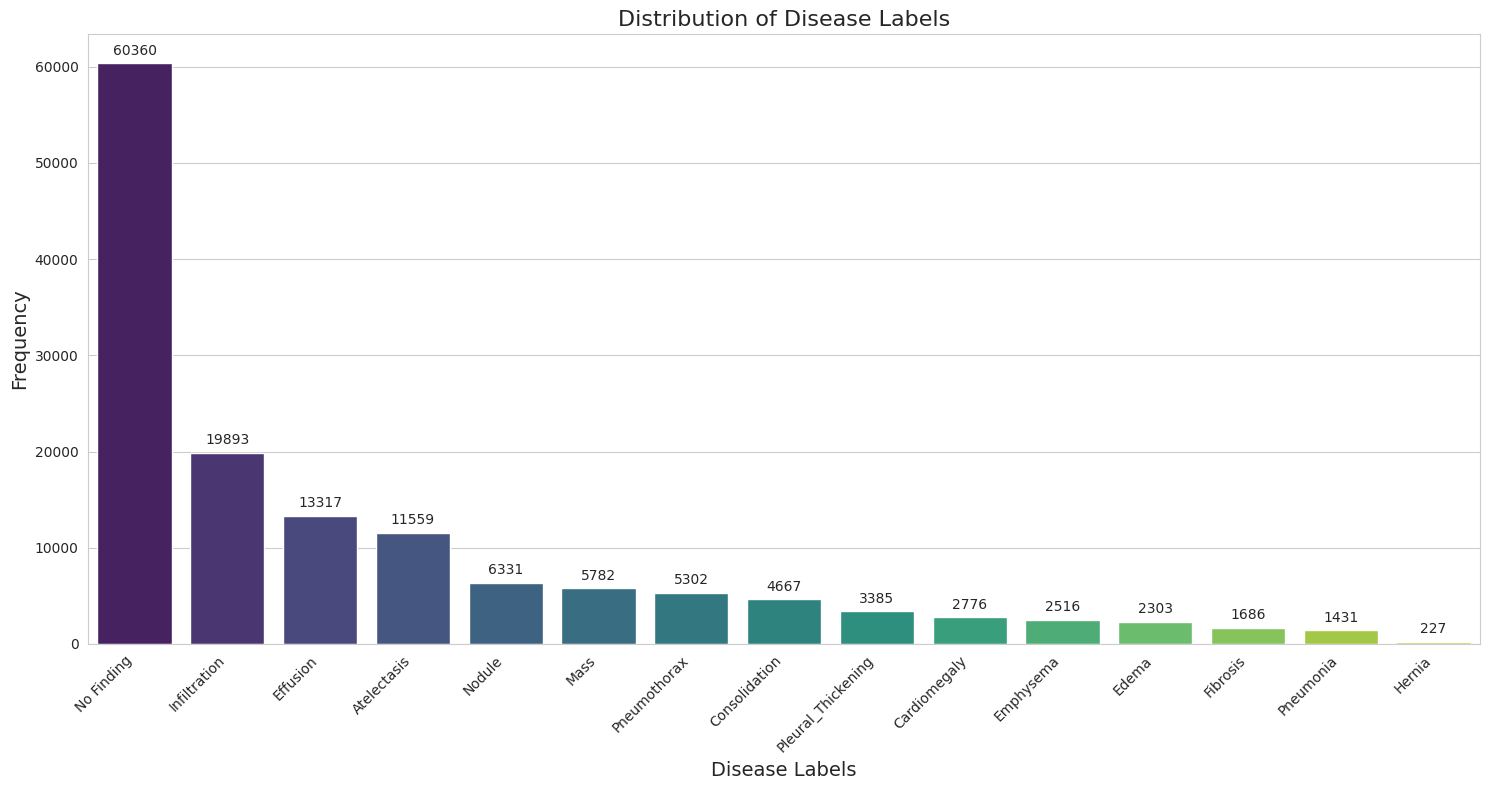

In [ ]:
label_counts = Counter()
for labels in df['Finding Labels']:
    label_counts.update(labels.split('|'))

label_counts_series = pd.Series(label_counts).sort_values(ascending=False)

# --- Plotting the Visualization ---

sns.set_style("whitegrid")
plt.figure(figsize=(15, 8))
ax = sns.barplot(x=label_counts_series.index, y=label_counts_series.values, palette='viridis', hue=label_counts_series.index, legend=False)
plt.title('Distribution of Disease Labels', fontsize=16)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Disease Labels', fontsize=14)
plt.xticks(rotation=45, ha='right')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
# Replace 'No Finding' with an empty string
df['Finding Labels'] = df['Finding Labels'].str.replace('No Finding', '')

# Get unique labels and create one-hot encoded columns
all_labels = (df['Finding Labels'].str.split('|', expand=True)
              .stack()
              .str.strip()
              .unique())
all_labels = [x for x in all_labels if len(x) > 0] # Remove empty strings

print('All Labels ({}): {}'.format(len(all_labels), all_labels))

# Create one-hot encoded columns for each label
for c_label in all_labels:
    df[c_label] = df['Finding Labels'].str.contains(c_label).astype(float)

All Labels (14): ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']


In [ ]:
df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
76866,00018867_031.png,Infiltration,31,18867,33,F,AP,3056,2544,0.139,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96329,00025359_000.png,,0,25359,52,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27623,00007189_001.png,,1,7189,52,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
all_labels

['Cardiomegaly',
 'Emphysema',
 'Effusion',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Atelectasis',
 'Pneumothorax',
 'Pleural_Thickening',
 'Pneumonia',
 'Fibrosis',
 'Edema',
 'Consolidation']

In [ ]:
# Create a single labels column with all 14 binary values
df.loc[:, 'labels_vec'] = df.apply(lambda row: [row[p] for p in all_labels], axis=1)

In [ ]:
print("Labels have been multi-hot encoded.")
df[['Image Index', 'Finding Labels', 'labels_vec'] + all_labels].head()

Labels have been multi-hot encoded.


,Image Index,Finding Labels,labels_vec,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,00000001_000.png,Cardiomegaly,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#@title Multi-Label Stratified Data Splitting
print("\nSplitting data into training, validation, and test sets...")

df_to_split = df.copy()
if USE_SUBSET:
    # To make stratification effective, we sample patients first, then stratify their images
    unique_patients = df_to_split['Patient ID'].unique()
    subset_patient_ids = np.random.choice(unique_patients,
                                          size=int(len(unique_patients) * SUBSET_FRACTION),
                                          replace=False)
    df_to_split = df_to_split[df_to_split['Patient ID'].isin(subset_patient_ids)]
    print(f"Using a subset of {len(df_to_split)} images for splitting.")


Splitting data into training, validation, and test sets...
Using a subset of 56246 images for splitting.


In [ ]:
# Prepare data for the stratifier (X=features, y=labels)
X = df_to_split['full_path'].values.reshape(-1, 1)
y = np.array(df_to_split['labels_vec'].tolist())

# Split into Train (70%) and a temporary set (30%)
stratifier_traintest = IterativeStratification(n_splits=10, order=1)
train_indices, temp_indices = next(stratifier_traintest.split(X, y))

train_df = df_to_split.iloc[train_indices]
temp_df = df_to_split.iloc[temp_indices]

# Split the temporary set (30%) into Validation (10%) and Test (20%)
X_temp = temp_df['full_path'].values.reshape(-1, 1)
y_temp = np.array(temp_df['labels_vec'].tolist())

stratifier_valtest = IterativeStratification(n_splits=3, order=1) # 1/3 of temp_df for validation
val_indices, test_indices = next(stratifier_valtest.split(X_temp, y_temp))

val_df = temp_df.iloc[val_indices]
test_df = temp_df.iloc[test_indices]

print("\nData split successfully:")
print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")



Data split successfully:
Train samples: 50621
Validation samples: 3750
Test samples: 1875


In [ ]:
# Create final arrays for the data pipelines
X_train, y_train = train_df['full_path'].values, np.array(train_df['labels_vec'].tolist())
X_val, y_val = val_df['full_path'].values, np.array(val_df['labels_vec'].tolist())
X_test, y_test = test_df['full_path'].values, np.array(test_df['labels_vec'].tolist())

In [ ]:
#@title Create TensorFlow Data Pipeline
# --- Image Augmentation Layers ---
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1),
  tf.keras.layers.RandomBrightness(factor=0.1),
], name="data_augmentation")

def parse_image(filepath, label):
    """Loads an image file and preprocesses it for the DenseNet model."""
    image = tf.io.read_file(filepath)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    # Normalize using ImageNet stats
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

def create_dataset(filepaths, labels, augment=False):
    """Creates a batched, prefetched, and optionally augmented tf.data.Dataset."""
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y),
                               num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Create the final datasets for training, validation, and testing
train_ds = create_dataset(X_train, y_train, augment=True)
val_ds = create_dataset(X_val, y_val)
test_ds = create_dataset(X_test, y_test)

print("Data pipelines created successfully.")

Data pipelines created successfully.


In [ ]:
# Check the output shape

sample = train_ds.take(1)
for images, labels in sample:
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)

Images batch shape: (32, 224, 224, 3)
Labels batch shape: (32, 14)


## **Obj 1: Model Comparison**

Model Buiding, Training and Evaluation

In [ ]:
#@title Define the Callbacks

# 1. Robust Metrics Callback to calculate macro-averaged AUC
# class MetricsCallback(tf.keras.callbacks.Callback):
#     def __init__(self, validation_dataset):
#         super().__init__()
#         self.validation_dataset = validation_dataset
#         self.y_true = np.concatenate([y for x, y in validation_dataset], axis=0)

#     def on_epoch_end(self, epoch, logs=None):
#         logs = logs or {}
#         y_pred = self.model.predict(self.validation_dataset, verbose=0)
#         class_aucs = []
#         # Calculate AUC for each class individually to handle single-class cases
#         for i in range(self.y_true.shape[1]):
#             try:
#                 with warnings.catch_warnings():
#                     warnings.simplefilter("ignore")
#                     class_auc = roc_auc_score(self.y_true[:, i], y_pred[:, i])
#                     class_aucs.append(class_auc)
#             except ValueError:
#                 pass # Ignore classes with no positive samples in the batch

#         if class_aucs:
#             logs['val_roc_auc'] = np.mean(class_aucs)
#             print(f" - val_roc_auc: {logs['val_roc_auc']:.4f}", end="")

# 2. Callback to save the best model weights based on validation AUC
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(MODELS_DIR, "deafnet_best.weights.h5"),
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# 3. Callback to stop training early if there's no improvement
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=5, # Stop after 5 epochs of no improvement
    verbose=1,
    restore_best_weights=True
)

# metrics_callback = MetricsCallback(validation_dataset=val_ds)
print("Callbacks are ready.")

Callbacks are ready.


In [ ]:
#@title Focal Loss Function

# Focal Loss implementation
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    """
    Focal Loss function for multi-label classification.
    alpha: Balances positive/negative examples.
    gamma: Modulates the easy/hard examples.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())

    # Calculate cross-entropy
    bce = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)

    # Calculate modulating factor for positive and negative samples
    p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    modulating_factor = tf.pow(1.0 - p_t, gamma)

    # Calculate alpha factor
    alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)

    focal_loss = alpha_factor * modulating_factor * bce
    return K.mean(focal_loss)

In [ ]:
#@title Advanced CNN - Dense-Efficient Attention-Fusion Network

class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, channels, **kwargs):
        super().__init__(**kwargs)
        self.channels = channels
        self.query_conv = Conv2D(channels, 1)
        self.key_conv   = Conv2D(channels, 1)
        self.value_conv = Conv2D(channels, 1)
        self.gamma = self.add_weight(
            name="gamma", shape=[1], initializer="zeros", trainable=True
        )

    def call(self, feat):
        batch, h, w, c = tf.shape(feat)[0], tf.shape(feat)[1], tf.shape(feat)[2], tf.shape(feat)[3]
        # Project to Q, K, V
        Q = self.query_conv(feat)  # (B, H, W, C)
        K = self.key_conv(feat)    # (B, H, W, C)
        V = self.value_conv(feat)  # (B, H, W, C)

        # Reshape to (B, H*W, C)
        Q_flat = tf.reshape(Q, [batch, -1, self.channels])
        K_flat = tf.reshape(K, [batch, -1, self.channels])
        V_flat = tf.reshape(V, [batch, -1, self.channels])

        # Attention scores
        scores = tf.matmul(Q_flat, K_flat, transpose_b=True)
        # Use the dtype of scores for the scaling factor to ensure type consistency
        scores = scores / tf.cast(tf.math.sqrt(tf.cast(self.channels, tf.float32)), scores.dtype)
        # For stability, softmax should be computed in float32
        A = tf.nn.softmax(tf.cast(scores, dtype=tf.float32), axis=-1)
        A = tf.cast(A, scores.dtype) # Cast back to the original dtype

        # Weighted sum
        out = tf.matmul(A, V_flat)  # (B, HW, C)
        out = tf.reshape(out, [batch, h, w, self.channels])

        # Learnable fusion
        return self.gamma * out + feat

class ResizeToMatch(tf.keras.layers.Layer):
    def call(self, inputs):
        source_features, target_features = inputs
        return tf.image.resize(source_features, tf.shape(target_features)[1:3])


def build_deafnet_model(input_shape,num_classes, fusion_channels=512, dropout_rate=0.5):
    """Builds the Dense-Efficient Attention-Fusion Network.

    This model uses two pre-trained backbones (DenseNet121 and EfficientNetB3)
    and fuses their features using an attention mechanism."""

    # Define the input layer
    input_tensor = Input(shape=input_shape)

    # --- Feature Extraction Streams ---
    # Stream 1: DenseNet121 Backbone
    densenet_base = DenseNet121(weights='imagenet', include_top=False, input_tensor=input_tensor)
    # Access output of a suitable layer for feature extraction
    densenet_features = densenet_base.get_layer('conv5_block16_concat').output

    # Stream 2: EfficientNetB3 Backbone
    # Access output of a suitable layer for feature extraction
    efficientnet_base = EfficientNetB3(weights='imagenet', include_top=False, input_tensor=input_tensor)
    efficientnet_features = efficientnet_base.get_layer('block6a_expand_activation').output


    # --- Attention-Based Feature Fusion ---
    # 1. Align feature maps using 1x1 Convolutions
    d_features_aligned = Conv2D(fusion_channels, (1, 1), padding='same', activation='relu')(densenet_features)
    e_features_aligned = Conv2D(fusion_channels, (1, 1), padding='same', activation='relu')(efficientnet_features)

    # Resize EfficientNet features to match DenseNet feature map size if they differ
    e_features_resized = ResizeToMatch()([e_features_aligned, d_features_aligned])

    # 2. Concatenate the aligned features
    fused_features = Concatenate(axis=-1)([d_features_aligned, e_features_resized]) # (B, H, W, 2*fusion_channels)

    # 3. Apply Cross-Attention Fusion
    attention = CrossAttention(channels=2*fusion_channels)(fused_features)

    # Pooling and dropout
    x = GlobalAveragePooling2D()(attention)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='sigmoid', dtype='float32', name='classifier')(x)

    deaf_net_model = Model(inputs=input_tensor, outputs=outputs, name='DEAF_Net')
    return deaf_net_model, densenet_base, efficientnet_base

# Build the model
deaf_net, densenet_backbone, efficientnet_backbone = build_deafnet_model(input_shape=(*IMG_SIZE, 3), num_classes=len(all_labels), fusion_channels=256, dropout_rate=0.5)

# Display model summary
print("-------------DEAF NET Model Summary: ------------------")
deaf_net.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
-------------DEAF NET Model Summary: ------------------


Model: "DEAF_Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 10,638,528 (40.58 MB)

 Trainable params: 10,521,273 (40.14 MB)

 Non-trainable params: 117,255 (458.03 KB)

In [ ]:
# --- Phase 1: Train the Fusion and Classification Layers Only ---
print("\n--- Starting Training Phase 1: Freezing Backbones---")
# Freeze the backbones
densenet_backbone.trainable = False
efficientnet_backbone.trainable = False

# Unfreeze Batch Normalization layers in the backbones
# Batch norm layers need to be trainable in mixed precision
for layer in deaf_net.layers:
    if hasattr(layer, 'layers'): # Check if it's a model/sequential layer
        for sub_layer in layer.layers:
            if isinstance(sub_layer, tf.keras.layers.BatchNormalization):
                sub_layer.trainable = True
    elif isinstance(layer, tf.keras.layers.BatchNormalization):
         layer.trainable = True


deaf_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=focal_loss,
    metrics=[tf.keras.metrics.AUC(name='auc', multi_label=True)]
)
model_name = "DEAFNet"
history_stage1 = deaf_net.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[model_checkpoint, early_stopping]
)


--- Starting Training Phase 1: Freezing Backbones---
Epoch 1/10
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.5409 - loss: 0.0264
Epoch 1: val_auc improved from -inf to 0.69301, saving model to /content/drive/MyDrive/Chest XRay/models/deafnet_best.weights.h5
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 2145s 1s/step - auc: 0.5409 - loss: 0.0264 - val_auc: 0.6930 - val_loss: 0.0171
Epoch 2/10
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - auc: 0.6121 - loss: 0.0169
Epoch 2: val_auc improved from 0.69301 to 0.71312, saving model to /content/drive/MyDrive/Chest XRay/models/deafnet_best.weights.h5
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 228s 143ms/step - auc: 0.6121 - loss: 0.0169 - val_auc: 0.7131 - val_loss: 0.0169
Epoch 3/10
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - auc: 0.6517 - loss: 0.0164
Epoch 3: val_auc improved from 0.71312 to 0.73394, saving model to /content/drive/MyDrive/Chest XRay/models/deafnet_best.weights.h5
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 229s 143ms/step - auc: 0.6517 - loss: 0.0164 -

In [ ]:
# Convert the history object to a Pandas DataFrame
history_stage1_df = pd.DataFrame(history_stage1.history)
history_stage1_df['epoch'] = history_stage1_df.index + 1
history_stage1_df['model'] = model_name

# Append to the CSV file, creating it if it doesn't exist
# Set header=False if the file already exists to avoid writing multiple headers
history_stage1_df.to_csv(HISTORY_CSV_PATH, mode='a', header=not os.path.exists(HISTORY_CSV_PATH), index=False)

print(f"Saved training history for {model_name} to {HISTORY_CSV_PATH}")

Saved training history for DEAFNet to /content/drive/MyDrive/Chest XRay/training_history.csv


In [ ]:
# --- Phase 2: Fine-Tune the Entire Network ---
print("\n--- Starting Training Phase 2: Fine-Tuning All Layers ---")
# Unfreeze the backbones
densenet_backbone.trainable = True
efficientnet_backbone.trainable = True

# Re-compile with a very low learning rate for fine-tuning
deaf_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=focal_loss,
    metrics=[tf.keras.metrics.AUC(name='auc', multi_label=True)]
)

history_stage2 = deaf_net.fit(
    train_ds,
    epochs=25, # Continue training for more epochs
    validation_data=val_ds,
    initial_epoch=len(history_stage1.epoch),
    callbacks=[model_checkpoint, early_stopping]
)
print("\nTraining complete.")


--- Starting Training Phase 2: Fine-Tuning All Layers ---
Epoch 11/25
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - auc: 0.7590 - loss: 0.0150
Epoch 11: val_auc improved from 0.79107 to 0.79547, saving model to /content/drive/MyDrive/Chest XRay/models/deafnet_best.weights.h5
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 666s 263ms/step - auc: 0.7590 - loss: 0.0150 - val_auc: 0.7955 - val_loss: 0.0153
Epoch 12/25
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - auc: 0.7675 - loss: 0.0149
Epoch 12: val_auc improved from 0.79547 to 0.80075, saving model to /content/drive/MyDrive/Chest XRay/models/deafnet_best.weights.h5
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 250s 157ms/step - auc: 0.7675 - loss: 0.0149 - val_auc: 0.8008 - val_loss: 0.0153
Epoch 13/25
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - auc: 0.7716 - loss: 0.0148
Epoch 13: val_auc improved from 0.80075 to 0.80685, saving model to /content/drive/MyDrive/Chest XRay/models/deafnet_best.weights.h5
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 250s 156ms/step - auc: 0.77

In [ ]:
# Convert the history object to a Pandas DataFrame
history_stage2_df = pd.DataFrame(history_stage2.history)
history_stage2_df['epoch'] = len(history_stage1_df) + history_stage2_df.index + 1
history_stage2_df['model'] = model_name

# Append to the CSV file, creating it if it doesn't exist
# Set header=False if the file already exists to avoid writing multiple headers
history_stage2_df.to_csv(HISTORY_CSV_PATH, mode='a', header=not os.path.exists(HISTORY_CSV_PATH), index=False)

print(f"Saved training history for {model_name} to {HISTORY_CSV_PATH}")

Saved training history for DEAFNet to /content/drive/MyDrive/Chest XRay/training_history.csv


In [ ]:
#@title Final Evaluation on the Test Set
print("\n--- FINAL EVALUATION ON TEST SET ---")

# Load the best weights saved by the ModelCheckpoint callback
print("Loading best model weights from training...")
deaf_net.load_weights(os.path.join(MODELS_DIR, "deafnet_best.weights.h5"))

# Evaluate the model on the unseen test data
results = deaf_net.evaluate(test_ds, return_dict=True, verbose=0)
print(f"\nTest Loss: {results['loss']:.4f}")
print(f"Test AUC (Keras built-in): {results['auc']:.4f}")

# Calculate the precise, macro-averaged AUC on the entire test set
print("\nCalculating precise AUC using scikit-learn...")
test_true = np.concatenate([y for x, y in test_ds], axis=0)
test_pred = deaf_net.predict(test_ds)
final_auc = roc_auc_score(test_true, test_pred, average='macro')
print(f"Test AUC (scikit-learn, macro-average): {final_auc:.4f}")

# Print class-wise AUC scores to see performance on each pathology
print("\n--- Class-wise Test AUC ---")
class_auc_scores = roc_auc_score(test_true, test_pred, average=None)
for i, pathology in enumerate(all_labels):
    print(f"{pathology:>20}: {class_auc_scores[i]:.4f}")


--- FINAL EVALUATION ON TEST SET ---
Loading best model weights from training...

Test Loss: 0.0152
Test AUC (Keras built-in): 0.8152

Calculating precise AUC using scikit-learn...
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 361ms/step
Test AUC (scikit-learn, macro-average): 0.8156

--- Class-wise Test AUC ---
        Cardiomegaly: 0.9060
           Emphysema: 0.9316
            Effusion: 0.8582
              Hernia: 0.9423
        Infiltration: 0.6773
                Mass: 0.8150
              Nodule: 0.7231
         Atelectasis: 0.7919
        Pneumothorax: 0.8286
  Pleural_Thickening: 0.7366
           Pneumonia: 0.6458
            Fibrosis: 0.8486
               Edema: 0.8633
       Consolidation: 0.8498


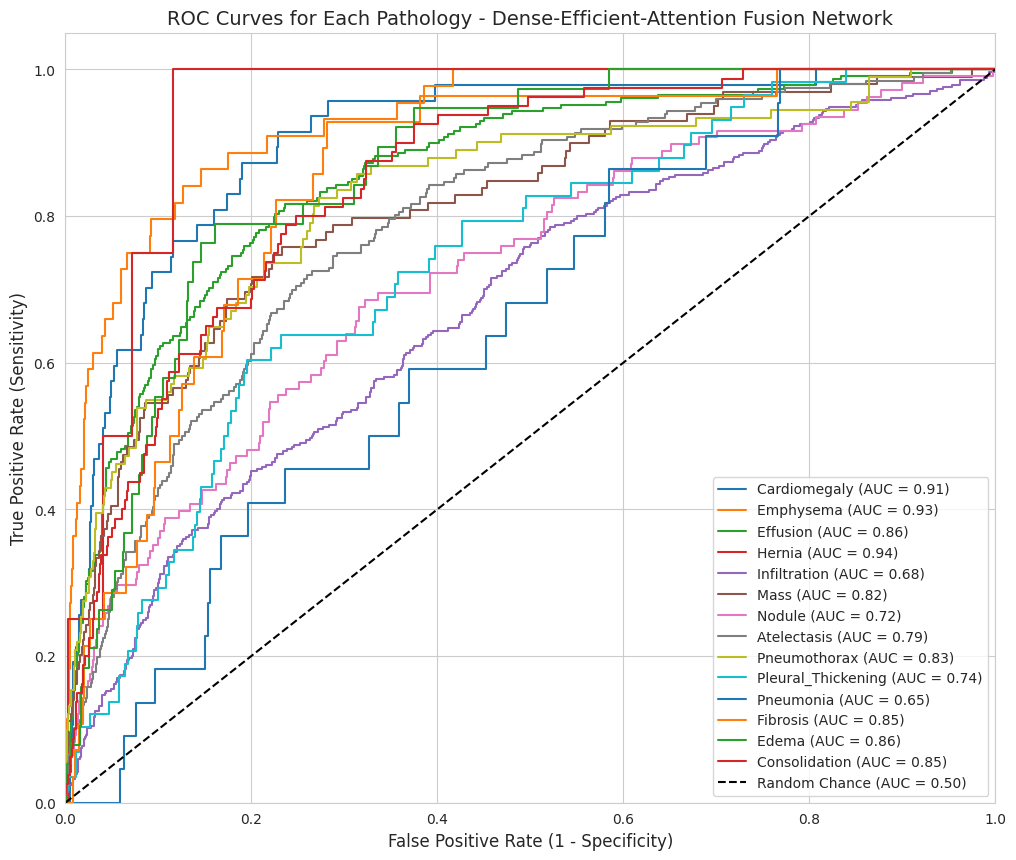

In [ ]:
#@title Plot ROC-AUC Curves for Each Class

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Set up the plot
plt.figure(figsize=(12, 10))

for i, pathology in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_true[:, i], test_pred[:, i])
    # Calculate the Area Under the Curve (AUC)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{pathology} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('ROC Curves for Each Pathology - Dense-Efficient-Attention Fusion Network', fontsize=14)

plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.show()

## **Uncertainty Estimation**

In [ ]:
def mc_dropout_predict_tf(model, image_tensor, num_samples):
    """
    Performs prediction using Monte Carlo Dropout.
    """
    # Create a list to store predictions from each forward pass
    predictions = []

    if tf.rank(image_tensor) == 3:
        image_tensor_batch = tf.expand_dims(image_tensor, 0)
    else:
        # Assumes the image tensor already has a batch dimension
        image_tensor_batch = image_tensor

    # Perform multiple forward passes
    for _ in range(num_samples):
        # Call the model with `training=True` to enable dropout at inference time
        output_probs = model(image_tensor_batch, training=True)
        predictions.append(output_probs.numpy())

    all_predictions = np.squeeze(np.array(predictions)) # Shape: (num_samples, num_classes)

    mean_probs = all_predictions.mean(axis=0)

    uncertainty = all_predictions.std(axis=0)

    return mean_probs, uncertainty, all_predictions

In [ ]:
data_iter = iter(test_ds)
images, labels = next(data_iter)

image_to_test = images[0]
true_label_vector = labels[0]
true_label_idx = np.argmax(true_label_vector) # Get the index of the true class

class_names = all_labels

# --- Perform MC Dropout Prediction ---
N_SAMPLES = 100  # Number of forward passes
deaf_net.load_weights(os.path.join(MODELS_DIR, "deafnet_best.weights.h5"))
mean_probabilities, uncertainty, all_preds = mc_dropout_predict_tf(deaf_net, image_to_test, N_SAMPLES)

# Get the final predicted class and its confidence
predicted_class_idx = np.argmax(mean_probabilities)
predicted_class_name = class_names[predicted_class_idx]
true_class_name = class_names[true_label_idx]
confidence = mean_probabilities[predicted_class_idx]

# --- Print and Interpret the Results ---
print("--- TensorFlow MC Dropout Results ---")
print(f"Image Ground Truth: {true_class_name}")
print(f"Model Prediction: {predicted_class_name} with {confidence:.2%} confidence")
print("-" * 35)

print("Class Probabilities (Mean):")
for i, class_name in enumerate(class_names):
    print(f"  - {class_name:<10}: {mean_probabilities[i]:.4f}")

print("\nPrediction Uncertainty (Standard Deviation):")
for i, class_name in enumerate(class_names):
    print(f"  - {class_name:<10}: {uncertainty[i]:.4f}")

uncertainty_threshold = 0.1
overall_uncertainty = uncertainty.mean()

print(f"\nAverage Uncertainty: {overall_uncertainty:.4f}")
if overall_uncertainty > uncertainty_threshold:
    print("Decision: High uncertainty detected. This case should be reviewed.")
else:
    print("Decision: Model is confident in its prediction.")


--- TensorFlow MC Dropout Results ---
Image Ground Truth: Atelectasis
Model Prediction: Atelectasis with 30.29% confidence
-----------------------------------
Class Probabilities (Mean):
  - Cardiomegaly: 0.1399
  - Emphysema : 0.1667
  - Effusion  : 0.2701
  - Hernia    : 0.0751
  - Infiltration: 0.2609
  - Mass      : 0.1711
  - Nodule    : 0.1817
  - Atelectasis: 0.3029
  - Pneumothorax: 0.2256
  - Pleural_Thickening: 0.1654
  - Pneumonia : 0.1044
  - Fibrosis  : 0.1196
  - Edema     : 0.0857
  - Consolidation: 0.1715

Prediction Uncertainty (Standard Deviation):
  - Cardiomegaly: 0.0199
  - Emphysema : 0.0186
  - Effusion  : 0.0173
  - Hernia    : 0.0131
  - Infiltration: 0.0146
  - Mass      : 0.0178
  - Nodule    : 0.0191
  - Atelectasis: 0.0154
  - Pneumothorax: 0.0204
  - Pleural_Thickening: 0.0170
  - Pneumonia : 0.0149
  - Fibrosis  : 0.0161
  - Edema     : 0.0139
  - Consolidation: 0.0187

Average Uncertainty: 0.0169
Decision: Model is confident in its prediction.


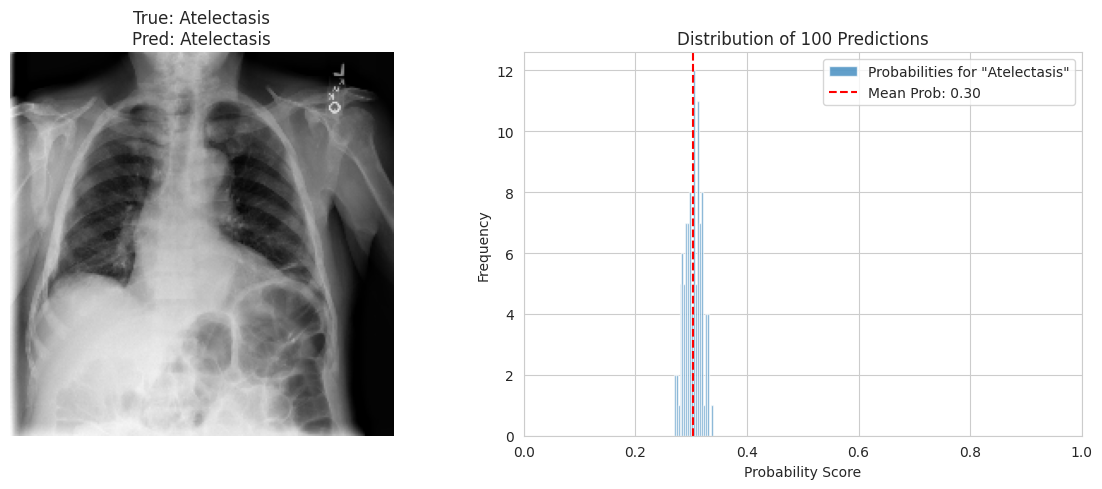

In [ ]:
# --- Visualize the Results ---
plt.figure(figsize=(12, 5))

# Plot the image itself
plt.subplot(1, 2, 1)

# Normalize the image tensor to the [0, 1] range for correct display
image_for_display = (image_to_test - tf.reduce_min(image_to_test)) / (tf.reduce_max(image_to_test) - tf.reduce_min(image_to_test))

plt.imshow(image_for_display)
plt.title(f"True: {true_class_name}\nPred: {predicted_class_name}")
plt.axis('off')

# Plot the distribution of probabilities for the predicted class
plt.subplot(1, 2, 2)
# `all_preds` has shape (N_SAMPLES, num_classes). We plot the column for the predicted class.
plt.hist(all_preds[:, predicted_class_idx], bins=20, alpha=0.7, label=f'Probabilities for "{predicted_class_name}"')
plt.axvline(confidence, color='r', linestyle='--', label=f'Mean Prob: {confidence:.2f}')
plt.title(f'Distribution of {N_SAMPLES} Predictions')
plt.xlabel("Probability Score")
plt.ylabel("Frequency")
plt.legend()
plt.xlim(0, 1)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


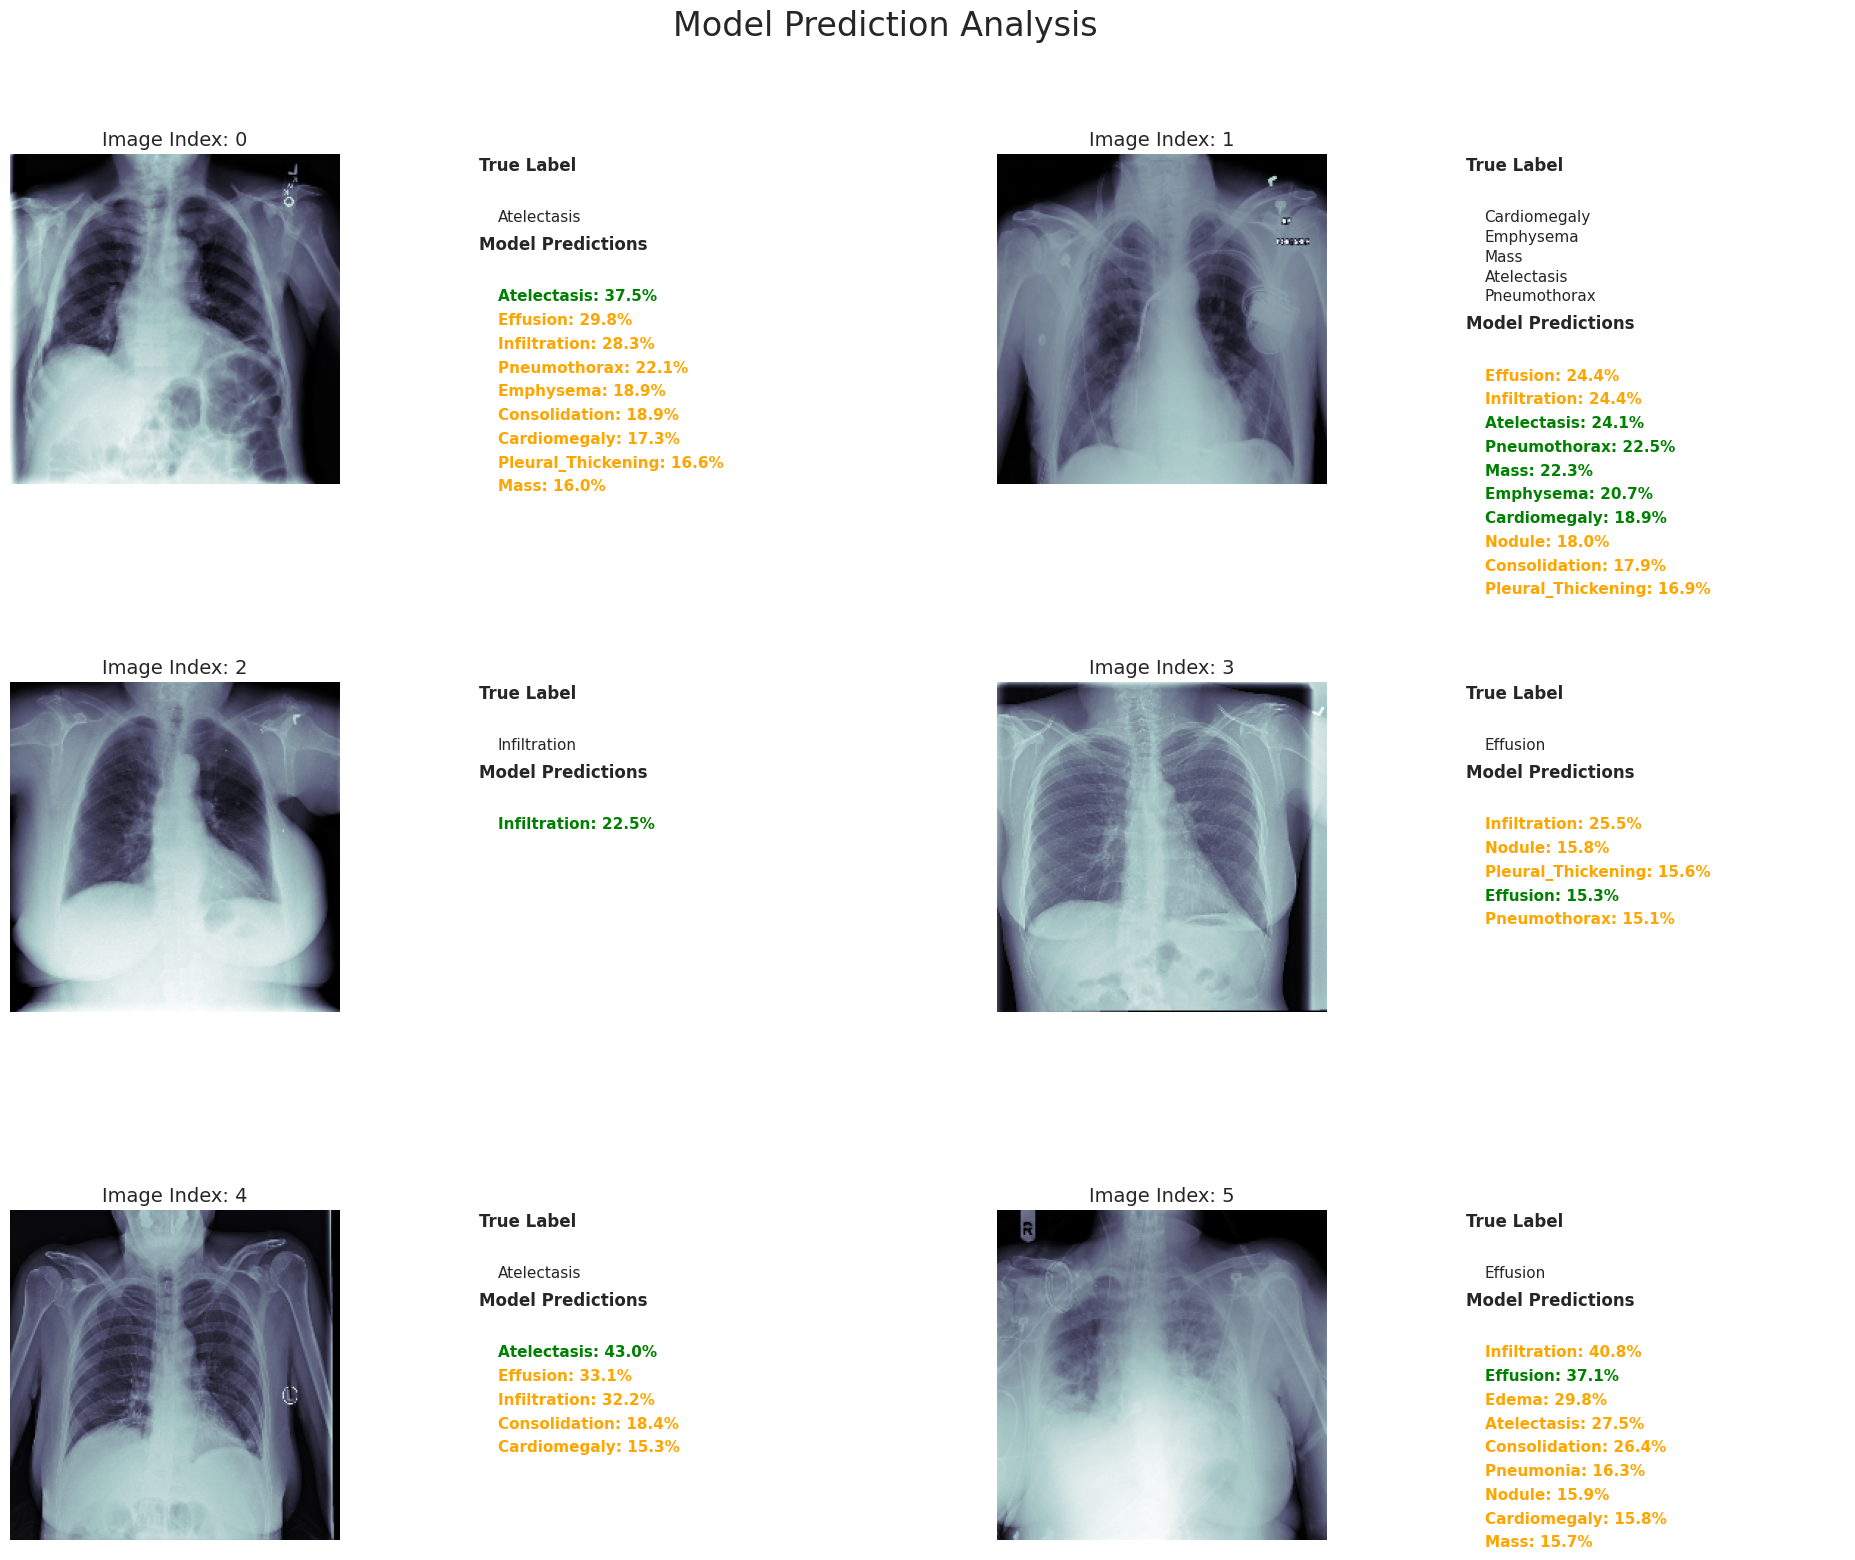

In [ ]:
import matplotlib.gridspec as gridspec

# --- Configuration ---
num_rows = 3
num_cols = 2
num_images_to_show = num_rows * num_cols  # Total images to display (6)
confidence_threshold = 0.15
colors = {'tp': 'green', 'fp': 'orange', 'fn': 'red'}

# --- Get Data and Predict ---
deaf_net.load_weights(os.path.join(MODELS_DIR, "deafnet_best.weights.h5"))

images, true_labels = next(iter(test_ds))
predictions = deaf_net.predict(images)

# --- Create the Visualization ---
fig = plt.figure(figsize=(24, 6 * num_rows))
# The grid will have `num_rows` and `num_cols * 2` columns (one for image, one for text)
gs = gridspec.GridSpec(num_rows, num_cols * 2, width_ratios=[1, 1] * num_cols, wspace=0.3, hspace=0.6)
fig.suptitle('Model Prediction Analysis', fontsize=24, y=0.96)

for i in range(num_images_to_show):
    # Calculate the grid position for the current result
    row_idx = i // num_cols
    col_idx_img = (i % num_cols) * 2
    col_idx_text = col_idx_img + 1

    image = images[i]
    true_label_vec = true_labels[i]
    pred_vec = predictions[i]

    # --- 1. Plot the Image ---
    ax_img = fig.add_subplot(gs[row_idx, col_idx_img])
    img_display = (image - tf.reduce_min(image)) / (tf.reduce_max(image) - tf.reduce_min(image))
    ax_img.imshow(np.mean(img_display, axis=-1), cmap='bone')
    ax_img.set_title(f"Image Index: {i}", fontsize=14)
    ax_img.axis('off')

    # --- 2. Display Analysis ---
    ax_text = fig.add_subplot(gs[row_idx, col_idx_text])
    ax_text.axis('off')

    y_pos = 0.95
    line_height = 0.12

    # Display Ground Truth
    ax_text.text(0, y_pos, "True Label", weight='bold', fontsize=12)
    y_pos -= line_height
    true_labels_present = [all_labels[j] for j, is_present in enumerate(true_label_vec) if is_present]
    if not true_labels_present:
        true_labels_present = ["No Finding"]
    for label in true_labels_present:
        ax_text.text(0.05, y_pos, label, fontsize=11, va='top')
        y_pos -= (line_height * 0.5)

    # Display Model Predictions (Color-Coded)
    y_pos -= (line_height * 0.5)
    ax_text.text(0, y_pos, "Model Predictions", weight='bold', fontsize=12)
    y_pos -= line_height

    display_items = []
    for j, label in enumerate(all_labels):
        is_true = true_label_vec[j] == 1
        prob = pred_vec[j]
        is_predicted = prob > confidence_threshold

        if is_true and is_predicted: # True Positive
            display_items.append({'label': label, 'prob': prob, 'color': colors['tp']})
        elif not is_true and is_predicted: # False Positive
            display_items.append({'label': label, 'prob': prob, 'color': colors['fp']})
        elif is_true and not is_predicted: # False Negative
            display_items.append({'label': label, 'prob': prob, 'color': colors['fn']})

    display_items.sort(key=lambda x: x['prob'], reverse=True)

    if not display_items:
        ax_text.text(0.05, y_pos, "No notable findings.", fontsize=11, va='top')
    else:
        for item in display_items:
            text = f"{item['label']}: {item['prob']:.1%}"
            ax_text.text(0.05, y_pos, text, color=item['color'], fontsize=11, va='top', weight='bold' if item['color'] != colors['fn'] else 'normal')
            y_pos -= (line_height * 0.6)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()